# Question 2 - $k$-means on Spark


### Setup

Let's setup Spark on your Colab environment.  Run the cell below!

In [1]:
!pip install pyspark
!pip install -U -q PyDrive2
#the output 'xxx is not a symbolic link' will not affect your implementation or execution
#to fix 'xxx is not a symbolic link', you can uncomment the lines starting from !mv xxxx
#you may need to replace xxx.11 with the correct version if other errors come up after colab update
#to get the correct version, use !ls /usr/local/lib to find out
!mv /usr/local/lib/libtbbmalloc_proxy.so.2 /usr/local/lib/libtbbmalloc_proxy.so.2.backup
!mv /usr/local/lib/libtbbmalloc.so.2 /usr/local/lib/libtbbmalloc.so.2.backup
!mv /usr/local/lib/libtbbbind_2_5.so.3 /usr/local/lib/libtbbbind_2_5.so.3.backup
!mv /usr/local/lib/libtbb.so.12 /usr/local/lib/libtbb.so.12.backup
!mv /usr/local/lib/libtbbbind_2_0.so.3 /usr/local/lib/libtbbbind_2_0.so.3.backup
!mv /usr/local/lib/libtbbbind.so.3 /usr/local/lib/libtbbbind.so.3.backup
!ln -s /usr/local/lib/libtbbmalloc_proxy.so.2.11 /usr/local/lib/libtbbmalloc_proxy.so.2
!ln -s /usr/local/lib/libtbbmalloc.so.2.11 /usr/local/lib/libtbbmalloc.so.2
!ln -s /usr/local/lib/libtbbbind_2_5.so.3.11 /usr/local/lib/libtbbbind_2_5.so.3
!ln -s /usr/local/lib/libtbb.so.12.11 /usr/local/lib/libtbb.so.12
!ln -s /usr/local/lib/libtbbbind_2_0.so.3.11 /usr/local/lib/libtbbbind_2_0.so.3
!ln -s /usr/local/lib/libtbbbind.so.3.11 /usr/local/lib/libtbbbind.so.3
#If error related to the above execution occurs, you can try commenting out the above 12 lines under pip install PyDrive2 (not included)

# !sudo ldconfig
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=d5664231e662fe3028ebd82aafddff3c25290b4d57523a7548f2165dd02df2f5
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.6 MB/s eta 0:00:00
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 32 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 M

Now we authenticate a Google Drive client to download the file we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [2]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
id='1wqmLKaPwHsmQd7Hq1k2frnwfYXcz8cOB'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('data.txt')

id='1I2SJRMgT-4EWRn--zrULV9ioDjHbpb5s'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('c1.txt')

id='1Ot72q_LJ1tRoEkwHMnPENdxHDYzO2A2H'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('c2.txt')

In [4]:
# Let's import the libraries we will need
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import DoubleType, ArrayType, FloatType

Let's initialize the Spark context.


In [5]:
# create the Spark Session
spark = SparkSession.builder.getOrCreate()

# create the Spark Context
sc = spark.sparkContext

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [6]:
spark

## a) Exploring initialization strategies with Euclidean distance

First read the document.

In [7]:
# Load data from data.txt
data = sc.textFile("data.txt").map(lambda line: list(map(float, line.strip().split(' '))))

# Load initial centroids from c1.txt and c2.txt
initial_centroids_c1 = sc.textFile("c1.txt").map(lambda line: list(map(float, line.strip().split(' '))))
initial_centroids_c2 = sc.textFile("c2.txt").map(lambda line: list(map(float, line.strip().split(' '))))

We will utilize the Euclidean distance metric to assign each point to the centroid that is closest, aiming to minimize the cost function $\phi = \sum_{x ∈ 𝑋} min_{c \in 𝐶} || x - c ||^2$.

In [8]:
def euclidean_distance(v1, v2):
    sez = [(a - b) ** 2 for a, b in zip(v1, v2)]
    s = 0
    for i in sez:
      s += i
    return math.sqrt(s)

In [9]:
def assign_cluster(point, centroids):
    min_distance = float('inf')
    closest_centroid = None
    for centroid in centroids:
        distance = euclidean_distance(point, centroid)
        if distance < min_distance:
            min_distance = distance
            closest_centroid = centroid
    return closest_centroid, min_distance ** 2

In [10]:
def compute_cost(data_rdd, centroids):
    return data_rdd.map(lambda point: assign_cluster(point, centroids)[1]).sum()

In each iteration, we update the centroids to be the mean of the current centroid positions.

In [11]:
def mean_point(data_list):
    n = len(data_list[0])
    mean = []
    for i in range(n):
        m = 0
        for l in data_list:
            m += l[i]
        mean.append(m/len(data_list))
    return mean

The main part of the program consists of 20 iterations. In each iteration, we compute the cost function and select new centroids using the previously defined functions.

In [12]:
def kmeans(data_rdd, initial_centroids_rdd):
    iterations = 20
    costs = []

    centroids = initial_centroids_rdd.collect()

    for i in range(iterations):
        cost = compute_cost(data_rdd, centroids)
        costs.append(cost)

        new_centroids = data.map(lambda point: (centroids.index(assign_cluster(point, centroids)[0]), point)).groupByKey().mapValues(list).map(lambda x: list(np.mean(x[1], axis=0)))
        centroids = new_centroids.collect()

    return costs

# Run K-means with initial centroids from c1.txt
costs_c1 = kmeans(data, initial_centroids_c1)

# Run K-means with initial centroids from c2.txt
costs_c2 = kmeans(data, initial_centroids_c2)


Plot the cost function for inital centroids from c1.txt and c2.txt.

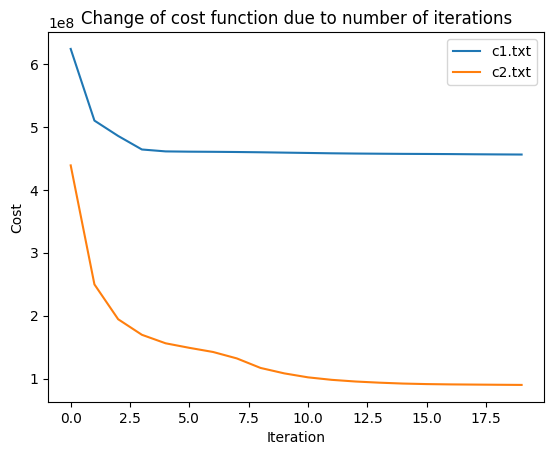

In [13]:
plt.plot(range(len(costs_c1)), costs_c1, label='c1.txt')
plt.plot(range(len(costs_c2)), costs_c2, label='c2.txt')

plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Change of cost function due to number of iterations')
plt.legend()
plt.show()

Calculate percentage change in cost after 10 iterations of the K-Means
algorithm when the cluster centroids are initialized using c1.txt vs. c2.txt.

In [14]:
(costs_c1[0]-costs_c1[10])/costs_c1[0] * 100

26.483917144560547

In [15]:
(costs_c2[0]-costs_c2[10])/costs_c2[0] * 100

76.69795594605947

## b) Exploring initialization strategies with Manhattan distance

Load the data again to reset the state to the starting point.

In [16]:
# Load data from data.txt
data = sc.textFile("data.txt").map(lambda line: list(map(float, line.strip().split(' '))))

# Load initial centroids from c1.txt and c2.txt
initial_centroids_c1 = sc.textFile("c1.txt").map(lambda line: list(map(float, line.strip().split(' '))))
initial_centroids_c2 = sc.textFile("c2.txt").map(lambda line: list(map(float, line.strip().split(' '))))

We will utilize the Manhattan distance metric to assign each point to the centroid that is closest, aiming to minimize the cost function $\psi = \sum_{x ∈ 𝑋} min_{c \in 𝐶} | x - c |$.

In [17]:
def manhattan_distance(v1, v2):
    s = 0
    for x, y in list(zip(v1, v2)):
      s += __builtin__.abs(x - y)
    return s

In [18]:
def assign_cluster_man(point, centroids):
    min_distance = float('inf')
    closest_centroid = None
    for centroid in centroids:
        distance = manhattan_distance(point, centroid)
        if distance < min_distance:
            min_distance = distance
            closest_centroid = centroid
    return closest_centroid, min_distance

In [19]:
def compute_cost_man(data_rdd, centroids):
    return data_rdd.map(lambda point: assign_cluster_man(point, centroids)[1]).sum()

In [20]:
def kmeans_man(data_rdd, initial_centroids_rdd):
    iterations = 20
    costs = []

    centroids = initial_centroids_rdd.collect()

    for i in range(iterations):
        cost = compute_cost_man(data_rdd, centroids)
        costs.append(cost)

        new_centroids = data.map(lambda point: (centroids.index(assign_cluster_man(point, centroids)[0]), point)).groupByKey().mapValues(list).map(lambda x: list(np.mean(x[1], axis=0)))
        centroids = new_centroids.collect()

    return costs

# Run K-means with initial centroids from c1.txt
costs_man_c1 = kmeans_man(data, initial_centroids_c1)

# Run K-means with initial centroids from c2.txt
costs_man_c2 = kmeans_man(data, initial_centroids_c2)


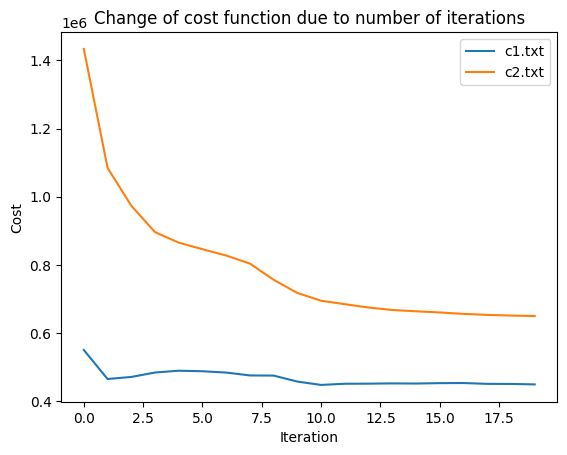

In [21]:
plt.plot(range(len(costs_man_c1)), costs_man_c1, label='c1.txt')
plt.plot(range(len(costs_man_c2)), costs_man_c2, label='c2.txt')

plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Change of cost function due to number of iterations')
plt.legend()
plt.show()

In [22]:
(costs_man_c1[0]-costs_man_c1[10])/costs_man_c1[0] * 100

18.654709691385904

In [23]:
(costs_man_c2[0]-costs_man_c2[10])/costs_man_c2[0] * 100

51.554099102389095